In [1]:
import torch
from PIL import Image
import torchvision.transforms as T

In [2]:
dinov2 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')

Using cache found in /home/roger/.cache/torch/hub/facebookresearch_dinov2_main
xFormers not available
xFormers not available


In [3]:
def interpolate_to_patch_size(img_bchw, patch_size):
    # Interpolate the image so that H and W are multiples of the patch size
    _, _, H, W = img_bchw.shape
    target_H = H // patch_size * patch_size
    target_W = W // patch_size * patch_size
    img_bchw = torch.nn.functional.interpolate(img_bchw, size=(target_H, target_W))
    return img_bchw, target_H, target_W

In [4]:
img = Image.open('meta_dog.png')

print(img.size)

transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.5], std=[0.5]),
])

img = transform(img)[:3].unsqueeze(0)

print(img.shape)

img, target_H, target_W = interpolate_to_patch_size(img, dinov2.patch_size)

print(img.shape)

(496, 322)
torch.Size([1, 3, 322, 496])
torch.Size([1, 3, 322, 490])


In [5]:
with torch.no_grad():
    features = dinov2.forward_features(img)["x_norm_patchtokens"][0]
    print(features.shape)

torch.Size([805, 384])


In [6]:
features.shape

torch.Size([805, 384])

In [7]:
features_hwc = features.reshape((target_H // dinov2.patch_size, target_W // dinov2.patch_size, -1))
features_chw = features_hwc.permute(2, 0, 1)
print(features_chw.shape)

torch.Size([384, 23, 35])


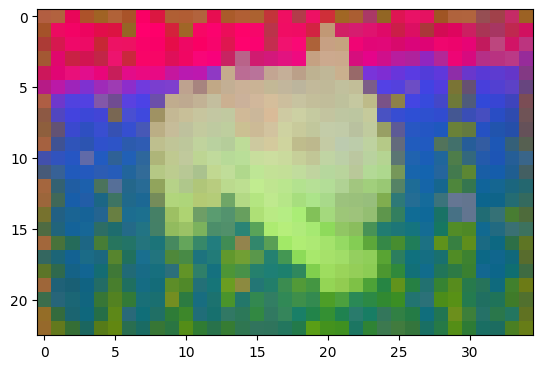

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
pca.fit(features)

pca_features = pca.transform(features)
pca_features = (pca_features - pca_features.min()) / (pca_features.max() - pca_features.min())
pca_features = pca_features * 255

plt.imshow(pca_features.reshape(target_H // dinov2.patch_size, target_W // dinov2.patch_size, 3).astype(np.uint8))